<center> 
    <h1> 
        Data Camp Project

 <center>
    <h1> 
        Prediction of the engagement rate on Instagram

# Table of content
1. [Introduction](#Introduction)
    - [Growing influence of Instagram](#See_later)
    - [Definition of the problem : Quantify the reaction to a post](#See_later)
2. [Data exploration](#Data_exploration)
    - [Data Processing](#Data_Processing)
    - [Top 50 : What are the kind of people in it ?](#See_later)
    - [Impact of the day of the week ?](#See_later)
    - [Analysis of the target](#See_later)
3. [Workflow](#Workflow)
4. [Submission](#Submission)

# Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re
import googletrans
import langid
import os
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import string
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
from nltk.stem.porter import PorterStemmer


nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simondemouchy/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Introduction

## Growing influence of Instagram

The leading treads towards social networking services had drawn massive
public attention from last one and half decade. The amount of data that is
uploaded to these social networking services is increasing day by day. So,
there is massive requirement to study the highly dynamic behavior of users
towards these services. Let's now focus of one the most used social networks : Instagram  
Instagram is an American photo and video sharing social networking service. In 2018, Instagram has reached 1 billion monthly active users. 

## Interest for Brands

Brands are currently aware of the growing influence of Instagram described above. As a result, they might see an interest to show up in Instragram. Because, this platforn is potentially a great canal of promotion. But to be efficient, a brand has to choose cleverly how it shows up in Instagram. And it why machine learning appeared as potentially relevant. Indeed, by collecting data on Instagram, a brand can find what kind of posts creates a lot of reactions.  
Before going deeper in the analysis, it is important to clearly define a metric to quantify the term "reaction".

## Definition of the problem : Predict the engagement rate on Instagram

**Engagement rate** is on of the most metric used to quanitfy the performance of a piece of content posted in social media, namely on Instagram. It can used also by influencers to measure the success of a campaign as evidence of their engaged audience. This metric is calculated based on number of likes, comments and followers as follows:  

<p style="text-align: center;">
$$ER = {n_{Likes} + n_{Comments} \over  n_{Followers}} \times 100$$

Scoring : "Root mean square error" which is defined by the following formula : 
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(ER_i-\hat{ER}_i)^2}$$

# Data exploration

In [ ]:
df_all = []
path = r'Data\2.Final_dataset'
arr = os.listdir(path)
for dirc in arr:
    df_all.append(pd.read_csv(path+'\\'+dirc))
    
df = pd.concat(df_all, axis=0)
df = df.drop(columns = ['Links to publication', 'Links to profile', 'Account description',
                       'Verified Status'])
df.columns = ['influencer','pr_activity','num_posts','num_followers','num_followings','post_description',
             'num_comments','num_likes','posting_date','media_type']

df = df.reset_index(drop=True)
print(df.shape)
df.head(3)

In [274]:
def clean(row):
    return str(row).replace(",","").replace(" ","")

df['num_likes'] = df['num_likes'].apply(clean).astype(int)  
df['num_comments'] = df['num_comments'].astype(int)
df['num_followers'] = df['num_followers'].apply(clean).astype(int)  
df['num_followings'] = df['num_followings'].apply(clean).astype(int) 
df['num_posts'] = df['num_posts'].apply(lambda x : x.replace("publications",""))
df['num_posts'] = df['num_posts'].apply(lambda x : x.replace("posts",""))
df['num_posts'] = df['num_posts'].apply(clean)
#Count the number of words in the description
df['num_words'] = pd.Series([len(re.findall(r'\w+', line)) for line in df['post_description']])
df['ER'] = ((df['num_likes'] + df['num_comments'])/df['num_followers'])*100

In [275]:
df.dtypes

influencer           object
pr_activity          object
num_posts            object
num_followers         int32
num_followings        int32
post_description     object
num_comments          int32
num_likes             int32
posting_date         object
media_type           object
num_words             int64
ER                  float64
dtype: object

## Top 50 : What are the kind of people in it ?

Before going deeper in the analysis of the dataset, it seems relevant to clearly understand and visualize who are the instagramers inside these top 50. Therefore, we are going to perform a clustering algorithm in order to identify the different kind of instagramers.

In [22]:
df = pd.read_csv('final_data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape

(21899, 24)

In [25]:
df.columns

Index(['influencer', 'pr_activity', 'num_posts', 'num_followers',
       'num_followings', 'post_description', 'num_comments', 'num_likes',
       'media_type', 'num_words', 'ER', 'year', 'month', 'day', 'hour',
       'Day_week', 'clean_post_description', 'num_hashtags', 'num_ref',
       'polarity', 'subjectivity', 'dominant_topic', 'perc_contribution',
       'sentiment'],
      dtype='object')

In [27]:
df_clst = df.drop(columns = ['post_description','num_words','clean_post_description',
                            'num_followings'])

df_clst['media_type'] = df_clst['media_type'].replace({'Video':0, 'Photo':1})

In [28]:
df_clst['pr_activity'] = df_clst['pr_activity'].apply(lambda x : x.lower())
df_clst['pr_activity'] = df_clst['pr_activity'].apply(lambda x : x.replace(' et ',''))
df_clst['pr_activity'] = df_clst['pr_activity'].apply(lambda x : x.replace('cienne','cien'))
df_clst['pr_activity'] = df_clst['pr_activity'].apply(lambda x : x.replace('trice','teur'))
df_clst['pr_activity'] = df_clst['pr_activity'].apply(lambda x : x.replace('comédienne','acteur'))
df_clst['pr_activity'] = df_clst['pr_activity'].replace({'footballeur':'Sportif',
                                        'joueur de basket-ball':'Sportif','acteur':'Acteur/Actrice',
                                        'acteurcatcheur professionnel':'Acteur/Actrice','magazine':'Marque',
                                        'vêtements':'Marque','musicienacteur':'Musicien/Musicienne',
                                        'club de football':'Marque', 'joueur de cricket':'Sportif',
                                        'ex-footballeur':'Sportif','agence spatiale':'Marque',
                                        'compétition de football':'Marque','acteurmusicien':'Acteur/Actrice',
                                        'lingerie':'Marque','modèle':'Modèle','musicien':'Musicien/Musicienne',
                                         'personnalité de téléréalitémodèle': 'Personnalité de téléréalité',
                                         'personnalité de téléréalité':'Personnalité de téléréalité'})

The distribution of the different kind of activities among the top 40 world's instagramers is shown below :

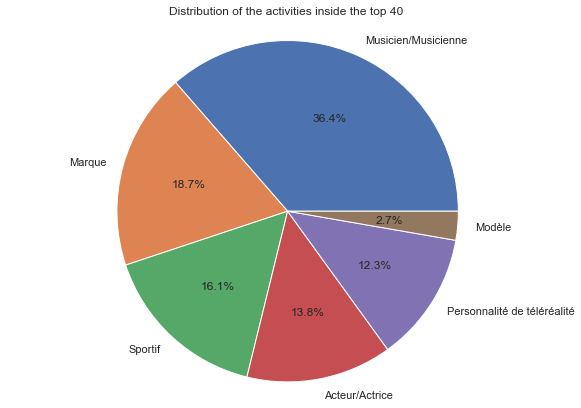

In [29]:
activity = df_clst['pr_activity'].value_counts() / df_clst.shape[0]

plt.figure(figsize=(10,7))
plt.pie(activity,
        labels=activity.index,
        autopct='%1.1f%%')
plt.title("Distribution of the activities inside the top 40")
plt.axis('equal')
plt.show()

In [279]:
df_clst = pd.concat([df_clst, pd.get_dummies(df_clst['pr_activity'],drop_first=True)],axis=1)
df_clst = df_clst.drop(columns = ['pr_activity'])

instagramers = df_clst.groupby(['influencer']).mean()
instagramers = instagramers.rename(columns = {'media_type':'%_photo'})
instagramers.head(3)

,num_followers,num_comments,num_likes,%_photo,ER,Marque,Modèle,Musicien/Musicienne,Personnalité de téléréalité,Sportif
influencer,,,,,,,,,,
Ariana Grande,215459527.0,22226.574713,4.426239e+06,0.718391,2.064641,0,0,1,0,0
Beyoncé,160470430.0,22203.320000,3.835023e+06,0.796667,2.403699,0,0,1,0,0
Cardi B,80744703.0,20480.886054,6.895557e+06,0.530612,8.565315,0,0,1,0,0


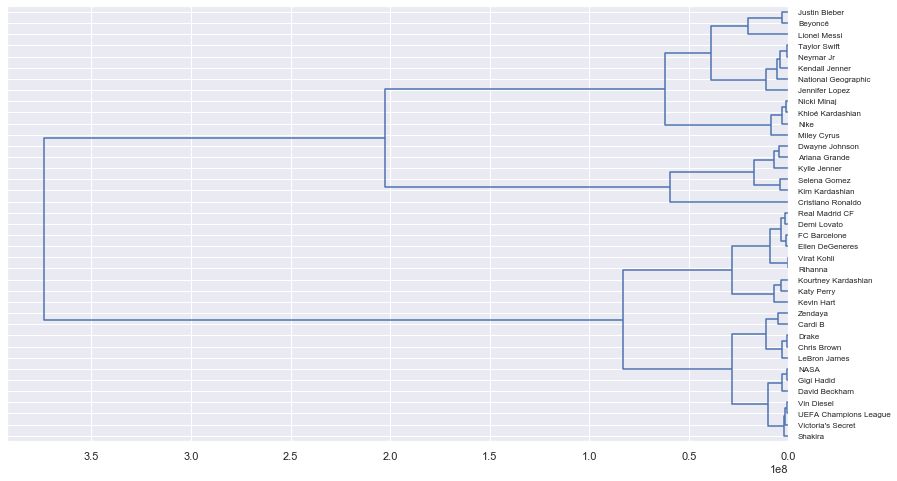

In [280]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

#Generate the links matrix
mat = linkage(instagramers,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.figure( figsize=(14,8) )
dendrogram(mat,labels=instagramers.index,orientation='left',color_threshold=0)
plt.show()

No handles with labels found to put in legend.


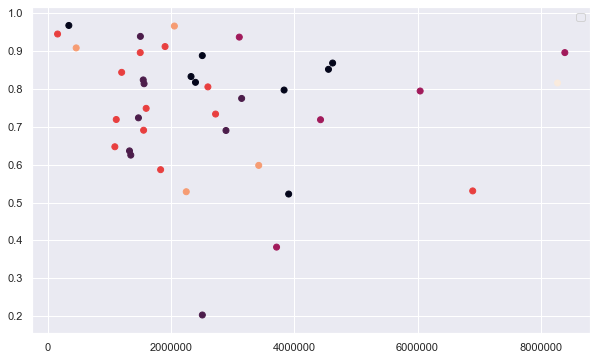

In [281]:
cah=AgglomerativeClustering(n_clusters=6,linkage='ward', compute_full_tree=True)
cah.fit(instagramers)

plt.figure(figsize=(10,6))
plt.scatter(instagramers['num_likes'],instagramers['%_photo'],c=cah.labels_)
plt.legend()
plt.show()

## Impact of the day of the week ?

In [282]:
df['posting_date'] = pd.to_datetime(df["posting_date"])
df['year'] = df['posting_date'].dt.year
df['month'] = df['posting_date'].dt.month
df['day'] = df['posting_date'].dt.day
df['hour'] = df['posting_date'].dt.hour
df['Day_week'] = df['posting_date'].dt.day_name()
df = df.drop(columns = ['posting_date'])

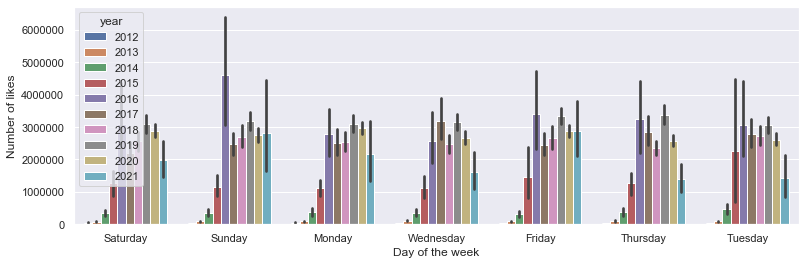

In [283]:
plt.figure(figsize=(13,4))
#sns.barplot(x = 'Day of the week of Posting',y = 'Post number of likes', data = df)
sns.barplot(x="Day_week", y="num_likes", hue="year", data=df)
plt.ylabel('Number of likes')
plt.xlabel('Day of the week')
plt.show()

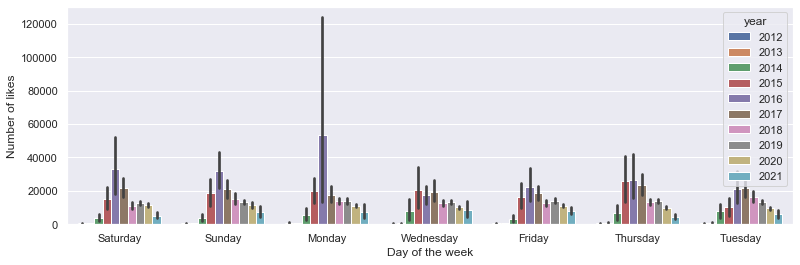

In [284]:
plt.figure(figsize=(13,4))
#sns.barplot(x = 'Day of the week of Posting',y = 'Post number of likes', data = df)
sns.barplot(x="Day_week", y="num_comments", hue="year", data=df)
plt.ylabel('Number of likes')
plt.xlabel('Day of the week')
plt.show()

## Analysis of the target

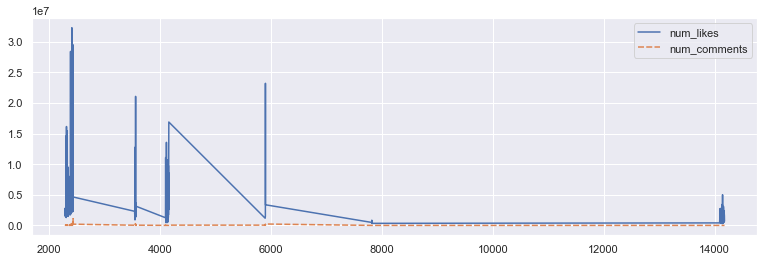

In [285]:
plt.figure(figsize=(13,4))
sns.lineplot(data=df[df['year'] == 2016][["num_likes","num_comments"]])

plt.show()

# Post Description Analysis

Moving past the general data exploration, we can dive in a little further by looking at the content of all the posts. To do so, we use Natural Language Processing to generate some features that we think would be useful to evaluate the post description performance and its impact on the number of likes and comments.  
- Before using NLP we clean the text by getting rid of number, emoticons, punctuation and stop words and focusing only on words that will be tokenized.
- Then, the words are reduced to its root using Stemming.

In [286]:
def Remove_Emojy(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def pre_process(text):
    text = Remove_Emojy(text)
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words and replace non-ascii characters
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [unidecode(w) for w in words if not w in stop_words]
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(WordNetLemmatizer().lemmatize(word)) for word in words]
    return " ".join(words)

In [287]:
df["clean_post_description"] = df["post_description"].apply(pre_process)

## Number of hashtags and References

In [288]:
def hashtags_num(text):
    return len(re.findall(r"#(\w+)", text))

def ref_num(text):
    return len(re.findall(r"@(\w+)", text))

In [289]:
df["num_hashtags"] = df["post_description"].apply(hashtags_num)
df["num_ref"] = df["post_description"].apply(ref_num)

## Positive or Negative Caption?

The variable **Polarity** which describes the the attitude, the emotion or the reaction of the influencer in the post, is generated by using the [TextBlob API](https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment) that has pre-defined semantic labels that gives an idea about a sentence either "Negative: -1", "Posive: 1" or "Neutral: 0". **Subjectivity** quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.  

In [290]:
from textblob import TextBlob

bloblist_desc = list()
for i in range(len(df['clean_post_description'])):
    blob = TextBlob(df['clean_post_description'].iloc[i])
    bloblist_desc.append((df['clean_post_description'].iloc[i],blob.sentiment.polarity, blob.sentiment.subjectivity))
    polarity_desc = pd.DataFrame(bloblist_desc, columns = ['clean_post_description','polarity','subjectivity'])

def sentimental_analysis(polarity_desc):
    if polarity_desc['polarity'] > 0:
        val = "positive"
    elif polarity_desc['polarity'] == 0:
        val = "neutral"
    else:
        val = "negative"
    return val

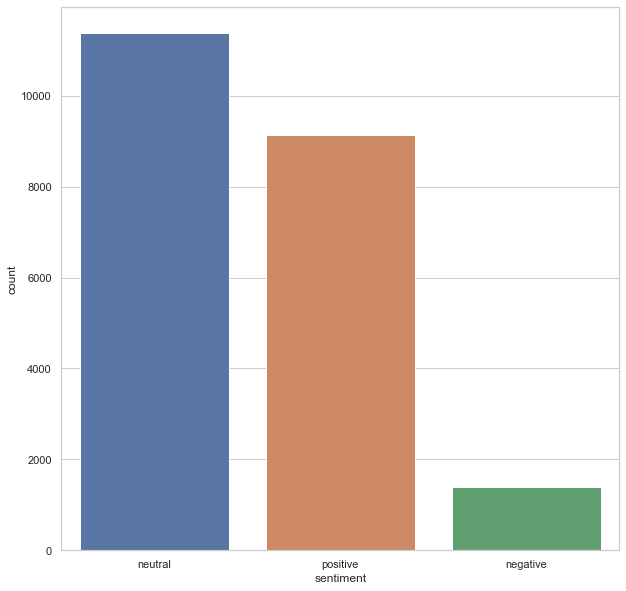

In [291]:
polarity_desc['sentiment'] = polarity_desc.apply(sentimental_analysis, axis=1)
df = pd.concat([df, polarity_desc[['polarity','subjectivity','sentiment']]], axis=1)
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="sentiment", data=polarity_desc)

## Topic modeling 

**Topic modeling** is a type of statistical modeling for finding out the abstract “topics” that in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. We use the constructor [gensim.models.LdaMulticore](https://tedboy.github.io/nlps/generated/generated/gensim.models.LdaMulticore.html) that estimates Latent Dirichlet Allocation model parameters based on a training corpus. Therefore, the dominant topic will be assigned to each post description.

In [294]:
import seaborn as sns
import gensim

tokens = []
for c in df['clean_post_description']:
    tokens.append(c.split())
dictionary = gensim.corpora.Dictionary(tokens)
bow_corpus = [dictionary.doc2bow(caption) for caption in tokens]
lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics=10,
                                   id2word = dictionary,                                    
                                   passes = 5,
                                   workers = 2)

def format_topics_sentences(ldamodel,corpus,description=df['clean_post_description']):#, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4)]),
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution']

    return sent_topics_df
df_topic_sents_keywords = format_topics_sentences(lda_model, bow_corpus)

In [295]:
df = pd.concat([df, df_topic_sents_keywords], axis=1)

In [300]:
df.to_csv(r'Data\final_data.csv')

# Workflow

The work flow is composed of two essential elements that make up the submission: the feature extractor and the regressor. The first allows both the preparation of initial data and the creation of new variables. The second, on the other hand, allows a supervised learning model to be trained so that the engagement rate on Instagram's post can be correctly predicted. This model is trained on a part of the base obtained from the feature extractor output, then is evaluated on the remaining part.

# Submission

## First model without NLP

To make a RAMP submission you will need to create a new directory within submissions, naming it as you wish, and a file named estimator.py within the new directory, e.g. submissions/my_new_sub/estimator.py

Within estimator.py, define a function named get_estimator that returns a scikit-learn pipeline or estimator that performs the desired feature extraction and regression.

For example, the estimator.py file below will perform the workflow detailed above

In [35]:
## Best let this part till the end so we can organize everything correctly :)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

def processing_data(df):
    
    X = df.copy()
    
    X['num_followings'] = X['num_followings'].astype(int)
    X['Number of posts'] = X['Number of posts'].apply(lambda x : x.replace("publications","")).apply(lambda x : x.replace(" ","")).astype(int)
    X['Post number of likes'] = X['Post number of likes'].apply(lambda x : x.replace(" ","")).astype(int)
    X['Media Type'] = df['Media Type'].replace({'Photo':0, 'Video':1})

    X['Number of words'] = pd.Series([len(re.findall(r'\w+', line)) for line in X['Post description']])
    
    X = X[['Number of followings','Number of posts','Post number of likes','Media Type','Number of words']]
    
    return X.values

# def processing_date(df):
    
#     X = df.copy()
    #we'll use th way we did before
#     X['Posting date'] = X['Posting date'].apply(lambda x : x.replace(':','-'))
#     X['Posting date'] = X['Posting date'].apply(lambda x : x.replace('T','-'))
#     X['Posting date'] = X['Posting date'].apply(lambda x : x.split('-'))

#     X['y'] = X['Posting date'].apply(lambda x : x[0]).astype(int)
#     X['m'] = X['Posting date'].apply(lambda x : x[1]).astype(int)
#     X['d'] = X['Posting date'].apply(lambda x : x[2]).astype(int)
#     X['h'] = X['Posting date'].apply(lambda x : x[3]).astype(int)
    
#     date_strings = []
#     for i in range(df.shape[0]):
#         d, m, y = X.loc[i,'d'], X.loc[i,'m'], X.loc[i,'y']
#         date_strings.append('{}-{}-{}'.format(d,m,y))
#     X['Date of Posting'] = pd.Series([pd.to_datetime(date, format='%d-%m-%Y') for date in date_strings])
#     X['day_week'] = X['Date of Posting'].dt.dayofweek
    
#     x_hour,x_day,x_month,x_year = np.array([X['h']]),np.array([X['d']]),np.array([X['m']]),np.array([X['y']])
#     x_day_week = np.array([X['day_week']])
    
#     return np.array([x_hour, x_day, x_month, x_year, x_day_week]).T.reshape(X.shape[0],5)
    
transformer_var = FunctionTransformer(
    lambda df: processing_data(df)
)
transformer_date = FunctionTransformer(
    lambda df: processing_date(df)
)

cols = ['Nationality', 'Brand']

transformer = make_column_transformer(
    (transformer_date, ['Posting date']),
    (transformer_date, ['Number of followings','Number of posts','Post number of likes',
                        'Media Type', 'Post description']),
    ('passthrough', cols),
)

pipe = make_pipeline(
    transformer,
    RandomForestRegressor()
)
    
def get_estimator():
    return pipe